In [76]:
# Some general initialisation
import math
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', context='talk')
%matplotlib notebook

def timeseries_plot(y, lags=None, figsize=(8, 6)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(1.5) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

# Steps
* Understand the question
* Understand the data
* Visualise
...

## Understand the question
What is the question being asked, what do we need to answer it and how do we measure our performance?

Often we want to create a model that captures all of the non-random noise within the signal.

## Understand the data
The first vital step is to understand the data

* Where did it come from?
    * How was it originally recorded? 
    * By whom? 
    * How frequently?
    * Under what conditions?
    * How accurately and consistently?
* Where has it been?
    * What other systems has it passed through? 
    * How has it been adjusted, aggregated, averaged, or otherwise massaged?
* Is it clean or dirty?
    * Are there data entry errors? 
    * Missing data? 
    * Misalignment of time periods? 
    * Changes in reporting practices? 
    * Bizarre events?
* What units is it measured? 
    * (1's or trillions? Dollars or customers or items sold? Price per item or price per kilo? Has it been seasonally adjusted, and if so, how? Is it measured in monthly totals or an annual rate? In nominal or constant (inflation-adjusted) units of currency? Does it represent the current level of something, or does it represent the absolute change from one period to another, or the percentage change from one period to another? Are the units compatible among variables?)


## Random Walk
Our brain will try and fool us into seeing patterns when none exists

<IPython.core.display.Javascript object>


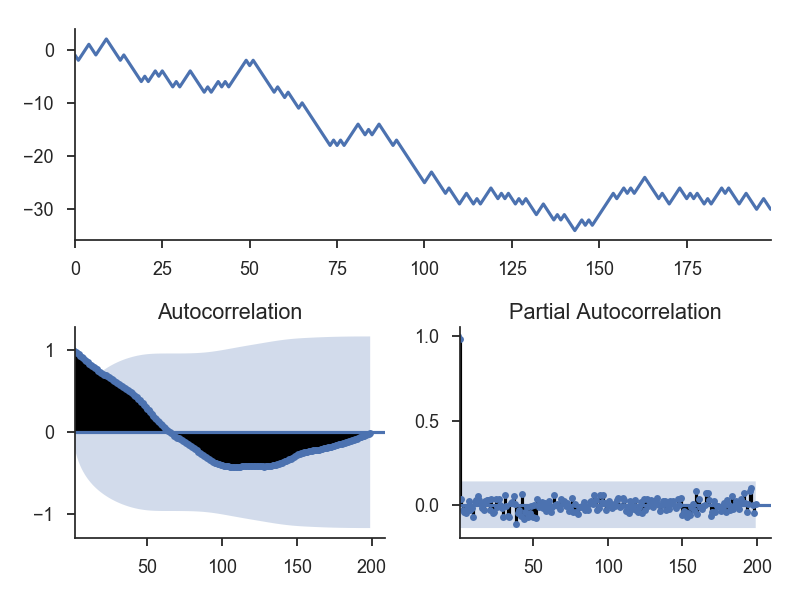

(<matplotlib.axes._subplots.AxesSubplot at 0x15ed2438>,
 <matplotlib.axes._subplots.AxesSubplot at 0x15f5db38>)

In [145]:
from random import seed
from random import random
seed(0.8)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 200):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)
#plt.plot(random_walk)
#plt.show()
timeseries_plot(pd.Series(random_walk))

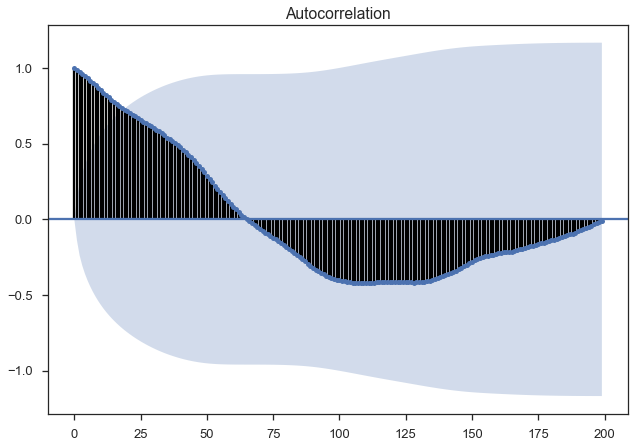

In [112]:
smt.graphics.plot_acf(random_walk)

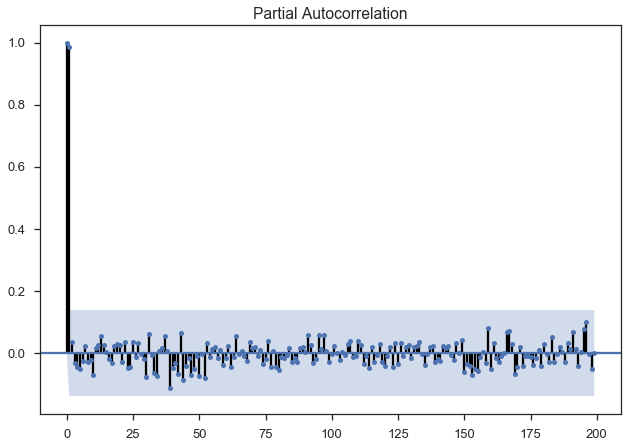

In [113]:
smt.graphics.plot_pacf(random_walk)

ADFuller test for a stationary time series. Here we would expect that the ADF is above the critical values and so we can accept the null hypothesis that the time seriees is non-stationary.

In [114]:
# statistical test
result = adfuller(random_walk, maxlag=50)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -1.210081
p-value: 0.669244
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575


Just to prove a point, using the same seed we expand the series from 200 to 4000 samples.

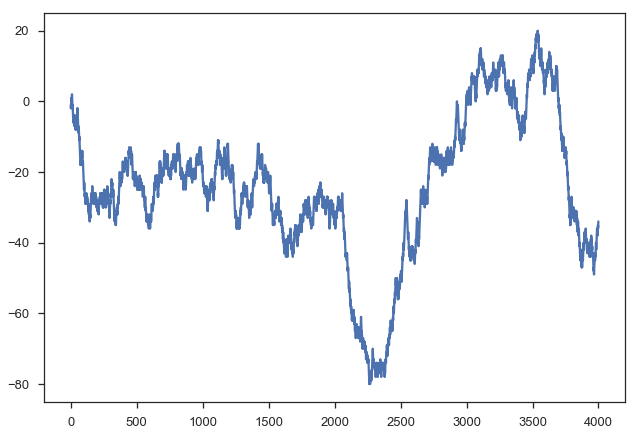

In [123]:
from random import seed
from random import random
seed(0.8)
random_walk = list()
random_walk.append(-1 if random() < 0.5 else 1)
for i in range(1, 4000):
    movement = -1 if random() < 0.5 else 1
    value = random_walk[i-1] + movement
    random_walk.append(value)
plt.plot(random_walk)
plt.show()

Do similar for a stationary time series whose mean, variance and autocorrelation remain consistant over time. 

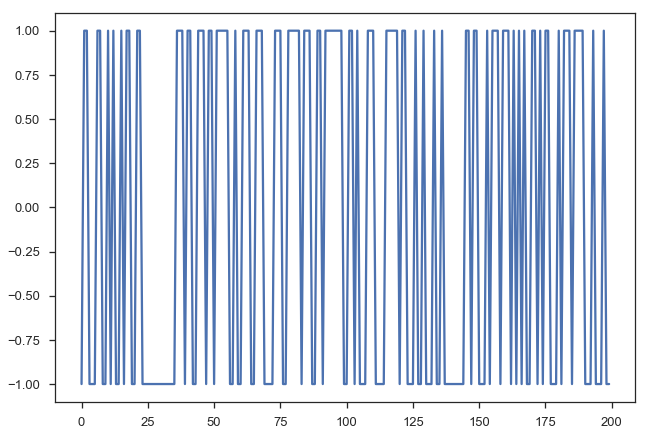

In [117]:
random_walk2 = list()
last = 1
seed(1)
for i in range(0, 200):
    random_walk2.append(0 + (-1 if random() < 0.5 else 1))
    last = last + 1
    
plt.plot(random_walk2)
plt.show()

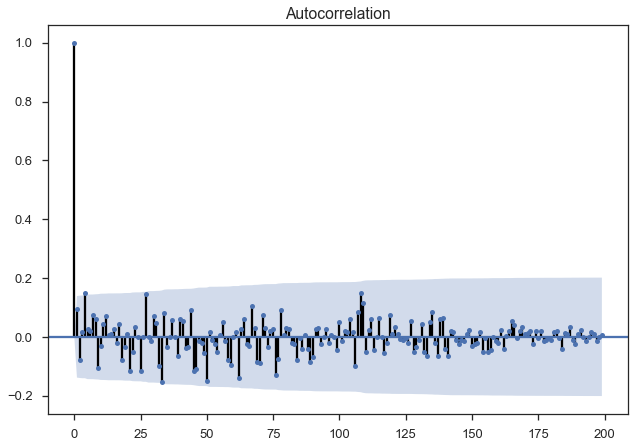

In [118]:
smt.graphics.plot_acf(random_walk2)

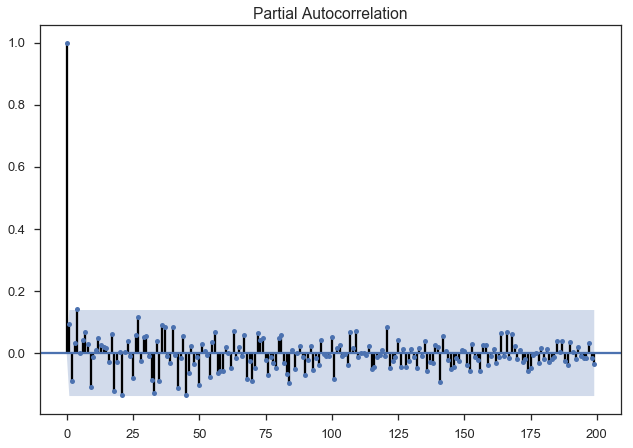

In [119]:
smt.graphics.plot_pacf(random_walk2)

ADFuller test for a stationary time series. Here we would expect that the ADF is below the critical values and so we can reject the null hypothesis and say the time series is stationary.

In [120]:
# statistical test
result = adfuller(random_walk2, maxlag=50)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %b.3f' % (key, value))

ADF Statistic: -12.754139
p-value: 0.000000
Critical Values:
	1%: -3.464
	5%: -2.876
	10%: -2.575


# Feature Creation
Here we will look at creating some new features based upon historic values. 

The below assumes that the data has been resampled a fixed frequency, if this is not the case then some of the gradient / slope calculations will now be correct due to possible different time ('horizontal') windows.

In [98]:
data = {'time': [
    '2017-02-21 00:00:00.000000', 
    '2017-02-21 01:00:00.000000', 
    '2017-02-21 02:00:00.000000', 
    '2017-02-21 03:00:00.000000', 
    '2017-02-21 04:00:00.000000', 
    '2017-02-21 05:00:00.000000', 
    '2017-02-21 06:00:00.000000', 
    '2017-02-21 07:00:00.000000', 
    '2017-02-21 08:00:00.000000', 
    '2017-02-21 09:00:00.000000', 
    '2017-02-21 10:00:00.000000'], 
    'values': [1.0, 1.0, 2.0, 4, 6, 10, 6, 4, 2, 1, 0]}
df = pd.DataFrame(data, columns = ['time', 'values'])
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')

#methods work on the whole dataframe if we want.
#print(df.pct_change())
#print(df.diff())

# shift by 1 step to introduce the previous value into the current rows features. We can add multiple features
# for the different historical values by shifting different amounts
df['shift1'] = df['values'].shift(1)

# create difference from previous values. If we assume fixed horizontal size of 1 then this is 
# synonomous with the gradient as we are effectively dividing by 1.
df['diff'] = df['values'].diff()

# manually calculate difference from previous value. If we assume fixed horizontal size of 1 then 
# this is synonomous with the gradient as we are effectively dividing by 1.
df['diff_man'] = (df['values'] - df['values'].shift(1))

# manually calculate percentage change for single column
df['%_change'] = -1 * (1 - df['values'] / df['values'].shift(1))

# rolling window operations - note we do a shift here to not include the current value (only historic values)
df['r3_h_min'] = df['values'].shift(1).rolling(window=3).min()

# first value in window
first = lambda x: x[0]
df['r3_h_first'] = df['values'].shift(1).rolling(window = 3).apply(first)

# difference t-1 to t-3. If we assume fixed horizontal size of 1 then this is synonomous with the gradient
#  as we are effectively dividing by 1.
diff = lambda x: x[-1] - x[0]
df['r3_h_diff'] = df['values'].shift(1).rolling(window = 3).apply(diff)

# angle from start to end
angle = lambda x: math.degrees(math.atan(x[-1] - x[0]))
df['r3_h_angle_-1'] = df['values'].shift(1).rolling(window = 3).apply(angle)

# shift angle field by rolling window size to get the proceeding rolling window values.
df['r3_h_angle_-2'] = df['r3_h_angle_-1'].shift(3)

# we know angle will be in the range 90 (slope up) to -90 (slope down) so can easily 
# normalise based on this range.
df['r3_h_angle_-1_n'] = (df['r3_h_angle_-1'] + 90) / 180

print(df)

                     values  shift1  diff  diff_man  %_change  r3_h_min  \
time                                                                      
2017-02-21 00:00:00     1.0     NaN   NaN       NaN       NaN       NaN   
2017-02-21 01:00:00     1.0     1.0   0.0       0.0 -0.000000       NaN   
2017-02-21 02:00:00     2.0     1.0   1.0       1.0  1.000000       NaN   
2017-02-21 03:00:00     4.0     2.0   2.0       2.0  1.000000       1.0   
2017-02-21 04:00:00     6.0     4.0   2.0       2.0  0.500000       1.0   
2017-02-21 05:00:00    10.0     6.0   4.0       4.0  0.666667       2.0   
2017-02-21 06:00:00     6.0    10.0  -4.0      -4.0 -0.400000       4.0   
2017-02-21 07:00:00     4.0     6.0  -2.0      -2.0 -0.333333       6.0   
2017-02-21 08:00:00     2.0     4.0  -2.0      -2.0 -0.500000       4.0   
2017-02-21 09:00:00     1.0     2.0  -1.0      -1.0 -0.500000       2.0   
2017-02-21 10:00:00     0.0     1.0  -1.0      -1.0 -1.000000       1.0   

                     r3_

<IPython.core.display.Javascript object>


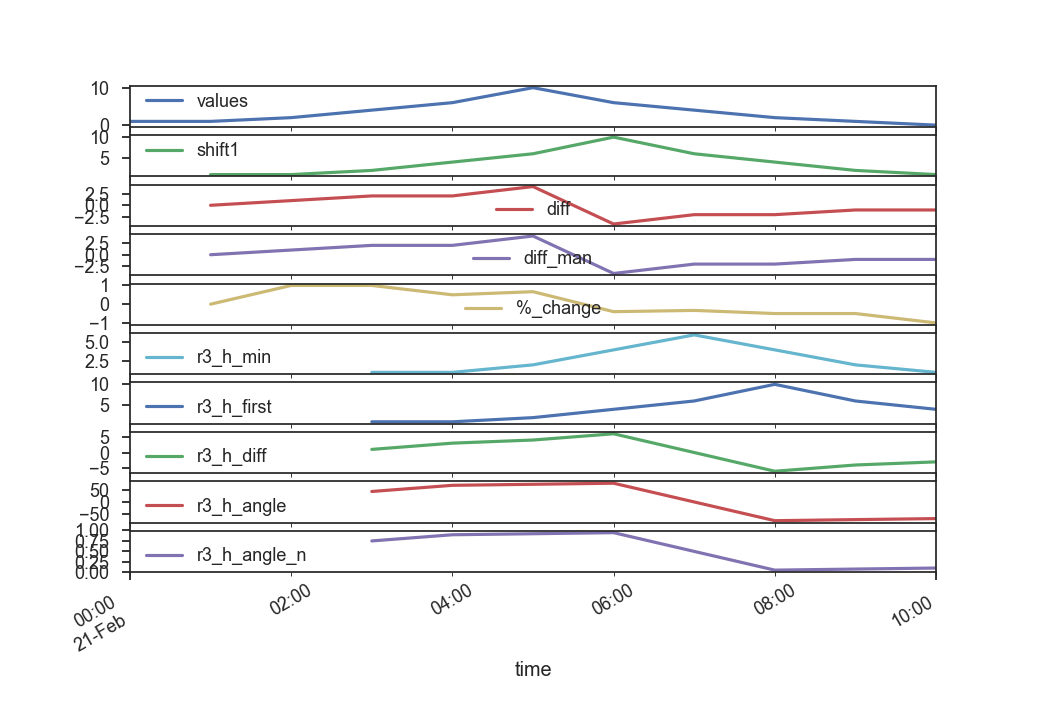

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000FC4D9E8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x0000000011496D30>], dtype=object)

In [92]:
df.plot(subplots=True)

In [50]:
df = sns.load_dataset('flights')
df.plot()

In [58]:
print(df)


     year      month  passengers
0    1949    January         112
1    1949   February         118
2    1949      March         132
3    1949      April         129
4    1949        May         121
5    1949       June         135
6    1949       July         148
7    1949     August         148
8    1949  September         136
9    1949    October         119
10   1949   November         104
11   1949   December         118
12   1950    January         115
13   1950   February         126
14   1950      March         141
15   1950      April         135
16   1950        May         125
17   1950       June         149
18   1950       July         170
19   1950     August         170
20   1950  September         158
21   1950    October         133
22   1950   November         114
23   1950   December         140
24   1951    January         145
25   1951   February         150
26   1951      March         178
27   1951      April         163
28   1951        May         172
29   1951 

IndexError: tuple index out of range